# HW4: Large Language Models

The first half of this assignment (Parts 0 and 1) will review some key ingredients of sequence modeling. In the process, we will build a baseline transformer model for next token prediction in code.
**The deliverable will be completing the questions posed in part 0 and part 1.**

The second half of the assignment (Part 2) will be an open-ended mini-project where you have the freedom to delve more deeply into language modelling (where the language in question is python code). Further instructions are in _Part 2: Mini-project_. But, in general, you should feel free to try other architectures (HMMs, RNNs, transformers, state space layers, diffusion models etc.) or to invent new architectures. The goal will be to find some area of possible improvement (we interpret "improvement" quite loosely, but it is up to you to state precisely in what sense your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not constitue an improvement according to your definition); to formulate and state a precise hypothesis; and to falsify or support the hypothesis with rigorous empirical analyses.
**The deliverable will be a report of no more than 4 pages (references not included in the page limit).**

**For this final assignment you have the option to work in pairs.**


> **<u>This Assignment</u>**
>
>**Model:** You will begin by implementing a baseline using attention and transformers. But, for the mini-project, you will be free to use any model (HMMs, RNNs, transformers, state space layers, diffusion models etc.) that you would like!
>
>**Algorithm:** mini-batched stochatic gradient descent / whatever you'd like! We will be using deep learning models in at least the first half of the assignment, so be sure to **use the GPU on colab** (make sure you switch to GPU in the "Runtime" tab above).
>
>**Data**: A large corpus of python code from [the Stack](https://huggingface.co/datasets/bigcode/the-stack-dedup). We have taken a dataset of around 4 million tokens from the stack and stored in a csv file for you for easy access.

## Setup

In [1]:
# can take around 30s
%%capture
! pip install datasets #huggingface datasets library
! pip install --upgrade pyarrow

In [2]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# hugging face imports
from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import numpy as np
import sys
import warnings

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# assert device=='cuda', "you need to change runtime type to GPU"

In [3]:
# hyperparams and helper functions
SMALL_ITERS = 1000
LARGE_ITERS = 2000
context_window_size = 256
chunk_size = 512 # BERT can only take max input size 512 characters

def chunk_string(string, size):
    """
    Splits a string into chunks of a specified size.

    :param string: The string to be chunked.
    :param size: The desired chunk size.
    :return: A list of string chunks.
    """
    return [string[i:i+size] for i in range(0, len(string), size)]

## Part 0: Preprocessing

As in the previous problem sets, a certain amount of preprocessing for textual data is required.

### 0.1: Loading the dataset

The first step is to actually download the dataset. We will be using a dataset on [huggingface](https://huggingface.co/). You can think of hugging face as the sklearn of deep learning.

The dominant mode for preprocessing textual data is to tokenize it, that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionary where counting numbers map to tokens. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research. For our baseline, we will use a tokenizer that microsoft created for code.

In [4]:
# mount to drive to save model weights
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('microsoft/CodeBERT-base')

In [6]:
# Load the concatenated data
raw_data = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2024/assignments/hw4/python_corpus_4M.csv", header=None)

In [7]:
# should take around 3 min to load in around 4M tokens
warnings.filterwarnings("ignore")

tokens = torch.tensor([], dtype=torch.long)
for index, row in raw_data.iterrows():
    text = row[0]
    chunks = chunk_string(text, chunk_size)
    n = len(chunks)
    for idx, chunk in enumerate(chunks):
        new_tokens = torch.tensor(tokenizer.encode(chunk, add_special_tokens=True))

        # logic to avoid incorrectly adding in start and end sequence tokens as an artifact of chunking
        if idx == 0:
            tokens = torch.cat((tokens, new_tokens[:-1]), dim=0)
        elif idx == n-1:
            tokens = torch.cat((tokens, new_tokens[1:]), dim=0)
        else:
            tokens = torch.cat((tokens, new_tokens[1:-1]), dim=0)

print(f"{len(tokens)} tokens have been loaded in")

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


4000596 tokens have been loaded in


### Question 0.2: Examining the tokenizer

Let's see what the tokens look like! We will use these two prompts during the assignment.

In [8]:
prompt_1_text = \
"""def newton(eta, N, X, y, gamma, beta=None):
  \"""
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  \"""

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):"""

In [9]:
prompt_2_text = \
"""import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    \"""Performs L2-Norm.\"""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    \"""Computes Euclidean distance.\"""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):"""

Here is what the tokenized output for the prompts looks like

In [10]:
tokenizer.decode(tokenizer.encode(prompt_1_text))

'<s>def newton(eta, N, X, y, gamma, beta=None):\n  """\n  Performs Newton\'s method on the negative average log likelihood with an\n  l2 regularization term\n\n  beta: torch.Tensor, of shape (teams)\n  X: torch.Tensor, the covariate matrix, of shape (-1, teams)\n  y: torch.Tensor, the response vector, of shape (teams)\n  gamma: float, the scale parameter for the regularization\n  beta: torch.Tensor, the starting point for gradient descent, if specified\n  """\n\n  if beta is None:\n    # Instantiate the beta vector at a random point\n    beta = torch.randn(X.shape[1])\n  else:\n    beta = torch.clone(beta)\n\n  loss = []\n\n  # Instantiate a list to store the loss throughout the gradient descent\n  # path\n  for i in tqdm(range(N)):</s>'

In [11]:
tokenizer.decode(tokenizer.encode(prompt_2_text))

'<s>import torch\nimport torch.nn.functional as F\n\n\ndef normalize(x, axis=-1):\n    """Performs L2-Norm."""\n    num = x\n    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12\n    return num / denom\n\ndef euclidean_dist(x, y):\n    """Computes Euclidean distance."""\n    m, n = x.size(0), y.size(0)\n    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)\n    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()\n    dist = xx + yy - 2 * torch.matmul(x, y.t())\n\n    dist = dist.clamp(min=1e-12).sqrt()\n\n    return dist\n\n\ndef cosine_dist(x, y):</s>'

And here are what the first and last 10 tokens for prompt 1 look like:

In [12]:
for tok in tokenizer.encode(prompt_1_text, add_special_tokens=True)[:10]:
    print(f"{tok} : {tokenizer.decode([tok])}")

0 : <s>
9232 : def
92 :  new
1054 : ton
1640 : (
8152 : eta
6 : ,
234 :  N
6 : ,
1577 :  X


In [13]:
for tok in tokenizer.encode(prompt_1_text)[-10:]:
    print(f"{tok} : {tokenizer.decode([tok])}")

326 :  t
1343 : q
43604 : dm
1640 : (
9435 : range
1640 : (
487 : N
43 : )
3256 : ):
2 : </s>


**Question 0.2**: What is the meanining of the `<s>` and the `<\s>` tokens? Why is it useful to have them?

They signal the start and end of a sequence of code to the model. This helps the model understand the context better--for example, if the model sees 5 tokens with a `<s>` token at the start, it would know that the sequence has just started and hence the predictions might be different than if it hadn't seen the start token (maybe code tends to have certain features like import statements or parameter definitions near start tokens).

Related to that, the start and end tokens help the model with generation--for example, the end token will signal to the model to stop producing code, which would prevent errors like incomplete code or infinite code.

### 0.3: Building our dataloader

There are around 50,000 tokens in the codebert vocab, but we only use around 20,000 of them. To make our lives easier, we just reindex the token indices to go from 1 to around 20,000.

In [14]:
# Get unique elements
extra_tokens = torch.cat((torch.tensor(tokenizer.encode(prompt_1_text, add_special_tokens=True)),
                          torch.tensor(tokenizer.encode(prompt_2_text, add_special_tokens=True))),
                         dim=0)

unique_tokens = torch.unique(torch.cat((tokens, extra_tokens), dim=0))

# Create a mapping from code bert to ids that increment by one
from_code_bert_dict = {element.item(): id for id, element in enumerate(unique_tokens)}

# Create a reverse mapping from ids to code bert token ids
to_code_bert_dict = {id: element for element, id in from_code_bert_dict.items()}

vocab_size = len(unique_tokens)
print(f"there are {vocab_size} distinct tokens in the vocabulary")

# helper functions to move between code bert and simple ids
def from_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of code bert tokens
    Returns:
    a list of simple ids
    """
    tkns = [int(from_code_bert_dict[token]) for token in tkn_lst]
    return tkns


def to_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of simple ids
    Returns:
    a list of code bert tokens
    """
    tkns = [int(to_code_bert_dict[token]) for token in tkn_lst]
    return tkns

there are 21970 distinct tokens in the vocabulary


In [15]:
# let's translate our dataset into our ids
tokens_simple_id = torch.tensor([from_code_bert_dict[token.item()] for token in tokens])

# split up the data into train and validation sets
n = int(0.9 * len(tokens_simple_id)) # first 90% will be train, rest val
train_data = tokens_simple_id.clone()[:n]
val_data = tokens_simple_id.clone()[n:]

print(f"there are {len(train_data)} tokens in the training set")
print(f"there are {len(val_data)} tokens in the validation set")
print(f"there are {vocab_size} distinct tokens in the vocabulary")

there are 3600536 tokens in the training set
there are 400060 tokens in the validation set
there are 21970 distinct tokens in the vocabulary


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [16]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [17]:
syntax_tokens = ['if', 'else', 'for', 'while', 'def', 'class', 'return', 'import', 'from', 'as','try','except',\
                          "+", "-", "*", "/", "=", "==", "<", ">", ";", "{", "}", "(", ")", ",","[", "]",\
                          "is", "#","print","range", "len", "True", "False", "None", "and", "or", "not", "in"]

syntax_tokens_ids = from_code_bert([tokenizer.encode(i, add_special_tokens=False)[0] for i in syntax_tokens])

In [18]:
xb, yb = get_batch("train", context_window_size, device)

## Part 1: Language Modeling

In this first part of the assignment, we will implement a baseline for code modeling.

In the process of building this baseline, we will review 4 key ideas of sequence modeling that have become the backbone of modern language modeling such as ChatGPT:

1. Framing language modeling as next token prediction, and next token prediction as multiclass logistic regression
2. Embedding discrete tokens in continuous latent spaces (word embeddings)
3. Use the attention mechanism to move beyond Markovian models for sequences (we of course pay for this greater expressivity with increased compute, which is made possible in part by using matrix multiplications on acccelerated hardware like GPUs. Reducing the compute burden while maintaining the expressivity needed for good sequence modeling is an active area of research).
4. Combining attention with deep learning in the Transformer architecture.

For various architectures that you have to train, we provide approximate training times and training loss scores for your reference. They are really just for reference so don't read too much into them, but we are providing them as a warning mechanism in case something is going seriously wrong.

### 1.1: Next token prediction as multiclass logistic regression

Our first language model will simply be a lookup table. That is, given that we have token with value $v$, we will simply "look up" the logits that correspond to our prediction for the next token. This model is often known as a "bigram model" because it can be derived from the relative proportions of different bigrams (ordered pairs of tokens) occurring in a large text corpus.

Let us be a bit more precise in our definition of the bigram model. Let's say that the total size of our vocabulary (the number of tokens we are using) is $V$. Let $A$ be a matrix in $\mathbb{R}^{V \times V}$, where each row $A_v$ corresponds to the logits for the prediction of which token would follow a token that has value $v$.
Thus, we are modeling the distribution of the token following a token that has value $v$ as
\begin{align*}
y_{t+1} \mid y_t &= v \sim \mathrm{Cat}(\mathbf{\pi}) \\
\pi &=\mathrm{softmax}(A_v)
\end{align*}

#### Question 1.1.1

$\mathbf{\pi} \in \Delta_{V-1}$ is the vector of probabilities used to parameterize the categorical distribution for the next token prediction. Explain why we parameterize
\begin{equation*}
  \mathbf{\pi} = \mathrm{softmax}(A_v),
\end{equation*}
and could not just use
\begin{equation*}
  \mathbf{\pi} = A_v.
\end{equation*}

---

Because in the latter case, $\pi$ would not necessarily sum to 1, and so would no longer be a vector of probabilities.

---

#### Question 1.1.2

Discuss the relationship between the bigram model and contigency tables (discussed in Lecture 2).

---

The bigram model involves the matrix $A$ and the $(i,j)$ element of $A$ contains the logits for token $j$ following token $i$. These logits are normalized to probabilities when a next token is sampled.

In contingency tables, the $(i,j)$ element of the table contains the count of how many times token $j$ followed token $i$ in the dataset. So it basically contains the frequency of each bigram.

---

#### Question 1.1.3

Say I have a string of three tokens with ids $(7, 3, 6)$. If I use the bigram model as a generative model for language, given this information, what is distribution of the fourth token?

---

From our data we can construct a frequency matrix:

$$
\begin{array}{c|ccc}
& 7 & 3 & 6 \\
\hline
7 & 0 & 1 & 0 \\
3 & 0 & 0 & 1 \\
6 & 0 & 0 & 0
\end{array}
$$

We haven't observed anything following a 6, so, after application of the softmax, the distribution of the fourth token would be uniform over $\{3, 6, 7\}$.

---

#### Question 1.1.4

Remember back in Section 0.2 "Tokenizing the data" when we gave you the helper function `get_batch`? Run `get_batch` and look at the inputs `x` and the targets `y`. Explain any relation between them in the context of formulating language modeling in the context of next token prediction.

In [ ]:
xb, yb = get_batch('train', 10, device, batch_size = 1)
print(f"the features have token ids {xb}")
print('\n')
print(f"the targets have token ids {yb}")

the features have token ids tensor([[ 8113,  7989,   125,  3687,   325,  1491,  1975,   105, 21047,  6630]],
       device='cuda:0')


the targets have token ids tensor([[ 7989,   125,  3687,   325,  1491,  1975,   105, 21047,  6630, 19900]],
       device='cuda:0')


The tokens with IDs in the targets are the tokens that come right after the tokens with IDs in the features. The target tokens are the feature tokens shifted to the left by 1.

So, at the first token in the features (8113), the goal is to predict the next token (7989). Hence, the first token in the targets is 7989, so that it lines up with 8113.

#### Question 1.1.5

Discuss the strengths and weaknesses of the bigram model as a generative model for language.

---

The bigram model assumes that you can find a distribution for the next token based only on the value of the current token. So a big weakness is that it doesn't take into account any long-range dependencies between tokens. For example, if I want to perform sentence generation and feed my model a sentence like "John eats an," the bigram model will only use the word "an" to predict the next work, which will give terrible predictions on average. It would do much better if it could use a larger context to make its prediction.

On the flip side, a huge advantage is that it has pretty low compute requirements. It's easy to implement, and darn fast to run compared to a transformer.

---

#### Question 1.1.6

Say I have a string $s$ of length $T$. Derive the formula for the negative log likelihood of $s$ under the bigram model in terms of the matrix of logits $A$. What would your answer be if the matrix of logits $A$ were all zeros? What would be the value of the negative log likelihood of $s$ under a model that always perfectly predicted the next token?

---

For some reason I could not convert this notebook to PDF via LaTeX with the markdown in this cell, so I have attached a screenshot separately on the last page. Please see the next page in the submission.

---



#### Question 1.1.7: Implement the BigramLanguageModel

Implement the bigram language model below.

Your TODOs:
  * if the `forward` method is provided a target, the loss should be the negative log likelihood of the target (given the context)
  * `generate` should take in (batched) contexts and a number of new tokens to generate, and then generate text from your model.


In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        """
        Args:
          vocab_size: size of the vocabulary (the number of tokens)
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.logits_table = nn.Embedding(vocab_size, vocab_size) # n=V, dim=V
        self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: Int(B, T), token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: Int(B, T), token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """

        # idx and targets are both (B,T) tensor of integers
        logits = self.logits_table(token_ids) # (B,T,V)

        if targets is None:
            loss = None
        else:
            # TODO: what should the loss in this setting be?
            # loss = ...

            logits = logits.view(-1, self.vocab_size)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets, reduction='mean')

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=context_window_size):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        # pass

        # strategy:
        # get the logits for the last token in the sequence
        # apply the softmax on those logits
        # sample from the resulting distribution
        # append the sample onto the sequence as the next generated token
        generated_tokens = token_ids # (B, T)

        for i in range(max_new_tokens):
          last_token = generated_tokens[:, -1] # get the last token for every sequence in the batch (B, 1)
          logits = self.logits_table(last_token) # (B, 1) -> (B, 1, V)
          pi = F.softmax(logits, dim=-1) # apply along the V dimension of logits (B, 1, V)
          next_token = torch.multinomial(pi, 1) # sample 1 item from each batch based on V
          generated_tokens = torch.concat((generated_tokens, next_token), dim=1) # (B, T+1)

        return generated_tokens


#### Question 1.1.8: Evaluating the initialization.

Evaluate the loss of your untrained bigram model on a batch of data. Does this loss make sense in the context of your answer to Question 1.1.6? Discuss.

In [ ]:
x,y = get_batch("train", context_window_size, device)
bigram_model = BigramLanguageModel(vocab_size)
bm = bigram_model.to(device)

# TODO: your code below

In [ ]:
x, y = x.to(device), y.to(device)
logits, loss = bm(x, y)

In [ ]:
loss

tensor(10.0046, grad_fn=<NllLossBackward0>)

In [ ]:
V = vocab_size
torch.log(torch.tensor(V))

tensor(9.9974)

---

In 1.1.6, we saw that if $A$ was all zeros (which it is in this case), then the loss for $T$ tokens would be $(T-1) \log V$, or about $\log V$ per token. In the two code cells above, we see that this indeed matches up with the loss we obtained!

---

#### Question 1.1.9: Training your bigram model

Train your bigram model for `SMALL_ITERS` iterations. Plot and interpret the loss curve.

Our train loss gets down to around 4 in around 5 min of training.

In [ ]:
# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=learning_rate)

eval_interval = 200
eval_iters = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm, eval_iters, context_window_size, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', context_window_size, device)

    # evaluate the loss
    logits, loss = bm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.5481, val loss 10.5376


 20%|██        | 200/1000 [00:52<02:53,  4.61it/s]

iteration 200


 20%|██        | 201/1000 [01:00<34:16,  2.57s/it]

step 200: train loss 8.2284, val loss 8.3207


 40%|████      | 400/1000 [01:43<02:09,  4.62it/s]

iteration 400


 40%|████      | 401/1000 [01:51<27:03,  2.71s/it]

step 400: train loss 6.2308, val loss 6.4694


 60%|██████    | 600/1000 [02:35<01:26,  4.62it/s]

iteration 600


 60%|██████    | 601/1000 [02:43<17:05,  2.57s/it]

step 600: train loss 4.8426, val loss 5.1550


 80%|████████  | 800/1000 [03:26<00:43,  4.62it/s]

iteration 800


 80%|████████  | 801/1000 [03:34<08:35,  2.59s/it]

step 800: train loss 4.2981, val loss 4.7244


100%|█████████▉| 999/1000 [04:17<00:00,  4.62it/s]

iteration 999


100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]

step 999: train loss 4.0000, val loss 4.5345


In [ ]:
torch.save(bm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/bm_state_dict.pth")
torch.save(bm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/bm.pth")

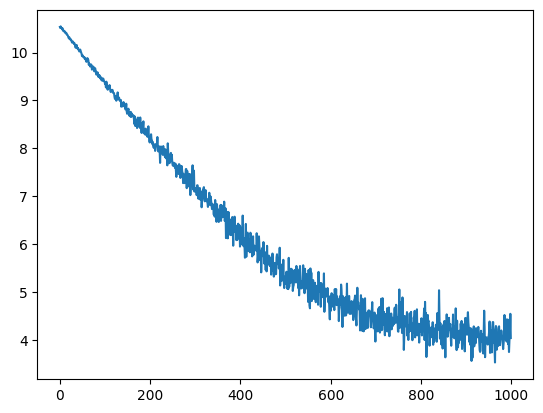

In [ ]:
plt.plot(loss_list)

---

The loss decreases steeply at the start, indicating that the model is learning quickly. Then it starts to level off towards the end, and the variance increases dramatically, indicating that maybe it's bouncing around near some local minimum.

---

### 1.2: Token Embeddings: going from discrete tokens to continuous latent spaces

In the look up table formulation of the bigram model, we are modelling the logits of the next token didstirbution independently for each token, even if two tokens are extremely similar to each other.
One way arond this problem is to learn an embedding of the discrete tokens into $\mathbb{R}^{D}$, and then to run multi-class logistic regression on top of this learned embedding.

More precisely, if we have a vocabulary of tokens of size $V$ that we choose to embed in a Euclidean embedding space of dimension $D$, we can parameterize the distribution of the next token if the current token is $v$ according to
\begin{align*}
  \mathrm{Cat}\Big( \mathrm{softmax} (\beta X_v) \Big),
\end{align*}
where $X_v \in \mathbb{R}^{D}$ is the learned embedding of token $v$ into $\mathbb{R}^{D}$ and $\beta \in \mathbb{R}^{V \times D}$. Notice that if $X$ were a fixed design matrix this formulation would be equivalent to multi-class logistic regression. However, both $X$ and $\beta$ are learnable parameters.

#### Question 1.2.1: Implement BigramWithWordEmbeddingsLM

Implement a bigram languge model that uses a linear readout from a low dimensional Euclidean embedding of each token to parameterize the logits of the next token distribution, instead of parameterizing the logits of the next token distribution directly. It should have almost the same implementation as `BigramLanguageModel` from Question 1.1.6, except `init` should also take in an `embed_size`, and the `forward` method will need to be modified.

In [ ]:
class BigramWithWordEmbeddingsLM(nn.Module):

    def __init__(self, vocab_size, embed_size=32):
      """
      Args:
        vocab_size: int, size of the vocabulary
        embed_size: int, dimension of the word embedding (D)
      """
      #TODO, your code here
      # pass
      super().__init__()
      self.logits_table = nn.Embedding(vocab_size, embed_size)
      self.beta = nn.Parameter(torch.randn(vocab_size, embed_size))

      self.linear = nn.Linear(embed_size, vocab_size)
      self.vocab_size = vocab_size
      self.embed_size = embed_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO, your code here

        # logits = None
        loss = None

        # Shape of embedded: [B, T, D]
        embeddings = self.logits_table(token_ids)

        logits = embeddings @ self.beta.T

        if targets is not None:
            # Compute log softmax on the logits
            log_probs = F.log_softmax(logits, dim=-1)

            # gather the log probabilities for the target tokens
            # shape of targets is [B, T], expand to [B, T, 1] to use with gather
            target_log_probs = log_probs.gather(dim=2, index=targets.unsqueeze(2)).squeeze(2)

            loss = - target_log_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=context_window_size):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        # pass
        # from BigramLanguageModel
        generated_tokens = token_ids # (B, T)

        for i in range(max_new_tokens):
          last_token = generated_tokens[:, -1] # get the last token for every sequence in the batch (B, 1)
          logits = self.logits_table(last_token) # (B, 1, V)
          pi = F.softmax(logits, dim=-1) # apply along the V dimension of logits (B, 1, V)

          next_token = torch.multinomial(pi, 1) # sample from the distribution (B, V) -> (B, 1)
          generated_tokens = torch.concat((generated_tokens, next_token), dim=1) # (B, T+1)

        return generated_tokens

In [ ]:
x,y = get_batch("train", context_window_size, device)
bigram_model = BigramWithWordEmbeddingsLM(vocab_size)
bm = bigram_model.to(device)
x, y = x.to(device), y.to(device)
logits, loss = bm(x, y)

In [ ]:
# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=learning_rate)

eval_interval = 200
eval_iters = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm, eval_iters, context_window_size, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', context_window_size, device)

    # evaluate the loss
    logits, loss = bm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 4/1000 [00:08<26:22,  1.59s/it]  

step 0: train loss 25.4935, val loss 25.5961


 20%|█▉        | 199/1000 [00:16<00:34, 23.35it/s]

iteration 200


 20%|██        | 205/1000 [00:24<07:42,  1.72it/s]

step 200: train loss 4.8104, val loss 5.3715


 40%|███▉      | 399/1000 [00:33<00:25, 23.30it/s]

iteration 400


 40%|████      | 405/1000 [00:41<05:42,  1.74it/s]

step 400: train loss 3.6802, val loss 4.3741


 60%|██████    | 600/1000 [00:49<00:17, 23.48it/s]

iteration 600


 60%|██████    | 603/1000 [00:57<05:21,  1.24it/s]

step 600: train loss 3.4046, val loss 4.0525


 80%|███████▉  | 798/1000 [01:05<00:08, 23.48it/s]

iteration 800


 80%|████████  | 804/1000 [01:13<01:54,  1.71it/s]

step 800: train loss 3.2670, val loss 3.9564


100%|█████████▉| 999/1000 [01:22<00:00, 22.18it/s]

iteration 999


100%|██████████| 1000/1000 [01:30<00:00, 11.08it/s]

step 999: train loss 3.1588, val loss 3.8667


In [ ]:
torch.save(bm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/bm_words_state_dict.pth")
torch.save(bm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/bm_words.pth")

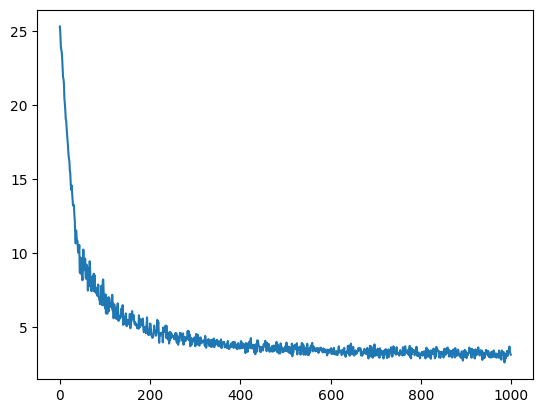

In [ ]:
plt.plot(loss_list)

Testing some code generation with this model:

In [ ]:
bigram_model = BigramWithWordEmbeddingsLM(vocab_size)
bm = bigram_model.to(device)
bm.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/bm_words_state_dict.pth"))

<All keys matched successfully>

In [ ]:
# the contexts for the different prompts
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")
# unconditional generate from the BM model
# uncond_gen = (bm.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist())
uncond_gen = bm.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(uncond_gen)))

context1_gen = bm.generate(token_ids=context1, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

context2_gen = bm.generate(token_ids=context2, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 1])
shape is torch.Size([1, 225])
shape is torch.Size([1, 263])
<s> in� that "'s it-� "'s with at ofs as its have have the from by's was said. it by with with at to on to by have have with " the it, the have have- said that,</s> are of at to as, be from in be on to was with to with was</s>� at at</s> said withs's have<s> in that are. the it for at at by with at�- and are. from by have from for have from as's are the and's as-'s, ", " a " in of for that- for said of at on<s> of " said at it's<s> be on on " are a is are that as and by�, are�'s<s> said said� as on with to� was for have� " in to</s> the that as fors at on at,- from</s> at with was to that to at have from was, with that as's of it�� that to on at with-� was " was to</s> on on from that<s> and at� " and on from " from with that that are was in was with,- from that on of are in, as, for at,. "s are at's to for
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negati

This is pretty bad code. Most glaringly, there are no line breaks, it looks like it's using some non-English characters too, and it also doesn't read much like code at all.

### 1.3: Attention: Relaxing Markovian assumptions to transmit information across the sequence length

A major problem with the bigram models of Sections 1.1 and 1.2 was that they were Markovian: the distribution of the next token was determined entirely by the current token! The attention mechanism provides a way to extract information between the previous tokens in the context to provide a better parameterization for the distribution of the next token.

#### Question 1.3.1: Averaging over word embeddings

One simple way to pool information from previous tokens would simply be to average the embeddings of all the previous tokens!

Your TODO: Add comments to the the code snippet below. Write a description here explaining why the code is mathematically equivalent to averaging the embeddings of previous tokens

---

The `attn_weights` tensor is a lower triangular matrix of 1's, and it multiplies each of the 8x2 sub-tensors within `X`. The `-inf` is to make sure that the 0's are excluded from the softmax calculation.

The resulting tensor `avgDmbds` is of the same shape as `X` (4x8x2).

In each 8x2 sub-tensor of the resulting tensor, the first row is just the first row of the corresponding tensor from `X`. The second row is the average of the first and second rows of the corresponding tensor from `X`. So, the last row is the average of all the rows from the corresponding tensor from `X`.

This way, each token in `avgDmbds` is the average of all tokens up to and including itself, but not including any tokens in front of it.

---

In [ ]:
# average word embedding via matrix multiply and softmax
batch_size = 4              # B
context_window_size = 8     # T
embed_size = 2              # D

# make "synthetic" word embeddings (for illustration purposes only)
X = torch.randn(batch_size, context_window_size, embed_size)

# TODO: comment the code below
print(X.shape)

# tril is a 8x8 tensor withs 1s on and below the diagonal and 0s above the diagonal
tril = torch.tril(torch.ones(context_window_size, context_window_size))

# intialize a zero tensor for attention weights
attn_weights = torch.zeros((context_window_size, context_window_size))

# fill in -inf above the diagonal
attn_weights = attn_weights.masked_fill(tril == 0, float('-inf'))

# apply the softmax along the rows (so each row sums to 1)
attn_weights = F.softmax(attn_weights, dim=-1)

# perform matmul of attn_weights with each 8x2 tensor inside X
# to get an up-to-and-including average of all previous token representations
# more elaboration on this in the explanation above
avgDmbds = attn_weights @ X
print(X[0])
print("")
print(avgDmbds[0])

torch.Size([4, 8, 2])
tensor([[-0.7692,  0.2216],
        [-1.0640, -0.1658],
        [ 1.2581,  0.2295],
        [ 0.2010,  0.1655],
        [ 0.5535, -0.2695],
        [-0.8832,  1.7995],
        [ 0.6452,  1.1533],
        [ 1.0591,  1.3576]])

tensor([[-0.7692,  0.2216],
        [-0.9166,  0.0279],
        [-0.1917,  0.0951],
        [-0.0935,  0.1127],
        [ 0.0359,  0.0363],
        [-0.1173,  0.3301],
        [-0.0084,  0.4477],
        [ 0.1251,  0.5615]])


#### 1.3.2: Single-headed scaled $(Q,K,V)$-attention

A more sophisticated approach than simply averaging over previous word embeddings is single-headed (Query, Key, Value) scaled attention.
That is, we now summarize the information contained in a length $T$ sequence of tokens that have been embeded into $X \in \mathbb{R}^{T \times D}$ according to
\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}
where $U_q, U_k \in \mathbb{R}^{K \times D}$, $V \in \mathbb{R}^{D \times D}$, and $K$ is the "head size".



##### Question 1.3.2.1

In the limiting case where $U_q$ and $U_k$ are all zeros, and $V = I_{D}$, what does $(U_q, U_k, V)$ attention simplify to?

---

Then the causal mask of the zero matrix returns a zero matrix, and the softmax across rows would turn each entry of a row into 1/(length of row) = $\frac{1}{T}$ (since $X U_q^T U_k X^T \in \mathbb{R}^{T \times T}$).

So the final expression simplifies to $\frac{1}{T} X$ (as $V$ is the identity).

---

##### Question 1.3.2.2

Imagine we had two matrices $U_q$ and $U_k$, both in $\mathbb{R}^{K \times D}$, where every entry was an independent standard normal.

What would be the distribution of an element of $U_q^\top U_k$? What about $U_q^\top U_k / \sqrt{K}$?

---

$[U_q^T U_k]_{ij} = [U_q]_i \cdot [U_k]_j = \sum_{k=1}^K [U_q]_{ik} [U_k]_{jk}$.
When $K$ is large, by the CLT, this sum would tend toward a normal with expectation 0 and variance $K$ (because if $X \sim N(0,1), Y \sim N(0,1)$ then $E(XY) = 0, Var(XY) = Var(X) Var(Y) = 1$ since they are independent; the sum of $K$ of these products will have expectation 0 and variance $K$).

Then for large $K$, $U_q^T U_k / \sqrt{K}$ would be normal with mean 0 and variance $K/K = 1$. So each entry in $U_q^T U_k / \sqrt{K}$ would be standard normal.

---

##### Question 1.3.2.3: Implement single-headed scaled $(U_q,U_k,V)$-attention.

Complete the below code so the `forward` method returns single-headed scaled $(U_q,U_k,V)$-attention.

In [20]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False) # input is of dim D, output is of dim K (so K x D)
        self.query = nn.Linear(embed_size, head_size, bias=False) # K x D
        self.value = nn.Linear(embed_size, embed_size, bias=False) # D x D

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        # pass
        K = self.key(x) # this is U_k @ X; sends (in_features D, out_features K) x (B, T, D) --> (B, T, K)
        Q = self.query(x) # sends (B, T, D) --> (B, T, K)
        V = self.value(x) # sends (B, T, D) --> (B, T, D)

        # (B, T, K) x (B, K, T) -> (B, T, T)
        attention_scores = Q @ K.transpose(-2, -1) / torch.sqrt(torch.tensor(self.head_size, dtype=x.dtype, device=x.device))

        # apply causal mask
        attention_scores = attention_scores.masked_fill(self.tril == 0, float('-inf'))

        # apply softmax along last dimension
        attention_weights = F.softmax(attention_scores, dim=-1)

        # multiply by values
        attention_output = attention_weights @ V # (B, T, T) x (B, T, D) --> (B, T, D)

        return attention_output # (B, T, D)

##### Question 1.3.2.3: Implement a single-headed attention language model

Complete the code below. Note that because the transformer has no idea where tokens are occuring in space, we have also added in position embeddings.

In [ ]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size) # num=V, dim=D
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size) # num=T, dim=D
      self.context_window_size = context_window_size # T

      # TODO: your code below
      # self.atten_head = Head(...)
      # self.lm_head = nn.Linear(...)
      self.atten_head = Head(head_size, context_window_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size) # input D, output V


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)

        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D) + (T, D) -> (B, T, D)
        x = self.atten_head(x) # (B, T, D) -> (B, T, D)
        logits = self.lm_head(x) # (B, T, D) -> (B, T, V)

        # TODO: your code here
        # logits = ...
        # loss = ...
        loss = None

        if targets is not None:
          # Compute log softmax on the logits
          log_probs = F.log_softmax(logits, dim=-1)

          # Gather the log probabilities for the target tokens
          # Shape of targets is [B, T], expand to [B, T, 1] to use with gather
          target_log_probs = log_probs.gather(dim=2, index=targets.unsqueeze(2)).squeeze(2)

          # Compute the loss as the mean of the negative log likelihood over all tokens
          # We start from the second token since the first token is always <s>
          # loss = -target_log_probs[:, 1:].sum(dim=1).mean()
          loss = - target_log_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        # pass

        # add padding in case the input isn't at least of length context_window_size 256
        generated_tokens = F.pad(token_ids, (256, 0), "constant", 0) # (B, T)

        for i in range(max_new_tokens):

          conditional_tokens = generated_tokens[:, -self.context_window_size:]
          logits, loss = self.forward(conditional_tokens)

          next_token_logits = logits[:, -1, :]
          probs = F.softmax(next_token_logits, dim=-1) # (B, 1, V)
          # Sample from the distribution or take the most likely token
          next_token = torch.multinomial(probs, num_samples=1) # (B, 1, V) -> (B, 1, 1)

          # Append the sampled token to the generated sequence
          generated_tokens = torch.cat((generated_tokens, next_token), dim=1) # (B, T+1)

        return generated_tokens[:, 256:] # get rid of the padded 0's

Train your new `SingleHeadedAttentionLM` for `SMALL_ITERS` training iterations and plot the loss curve.
The `head_size` shouldn't matter too much, we just use the `embedding_size`.
Do you seen an improvement compared to your `BigramLanguageModel`? Discuss.

Note: you may want to modify the learning rate. Training for `SMALL_ITERS` with a learning rate of `6e-4`, we can get to a train loss of around 3.4 in around 4 min of training.

In [ ]:
eval_interval = 200
eval_iters = 200

embed_size = 384
sha_model = SingleHeadedAttentionLM(vocab_size, context_window_size, embed_size, embed_size)
sham = sha_model.to(device)
learning_rate = 6e-4
optimizer = torch.optim.AdamW(sha_model.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(sham, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = sham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.0592, val loss 10.0593


 20%|██        | 200/1000 [00:48<01:53,  7.05it/s]

iteration 200


 20%|██        | 202/1000 [01:08<57:09,  4.30s/it]  

step 200: train loss 4.1658, val loss 4.3004


 40%|████      | 400/1000 [01:36<01:28,  6.80it/s]

iteration 400


 40%|████      | 402/1000 [01:57<44:12,  4.44s/it]  

step 400: train loss 3.8494, val loss 4.1476


 60%|██████    | 600/1000 [02:26<00:57,  6.90it/s]

iteration 600


 60%|██████    | 602/1000 [02:46<29:03,  4.38s/it]

step 600: train loss 3.6720, val loss 3.9887


 80%|████████  | 800/1000 [03:15<00:29,  6.84it/s]

iteration 800


 80%|████████  | 801/1000 [03:35<20:37,  6.22s/it]

step 800: train loss 3.4895, val loss 3.9105


100%|█████████▉| 999/1000 [04:04<00:00,  6.89it/s]

iteration 999


100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]

step 999: train loss 3.3558, val loss 3.8237


In [ ]:
torch.save(sham.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/sham_state_dict.pth")
torch.save(sham, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/sham.pth")

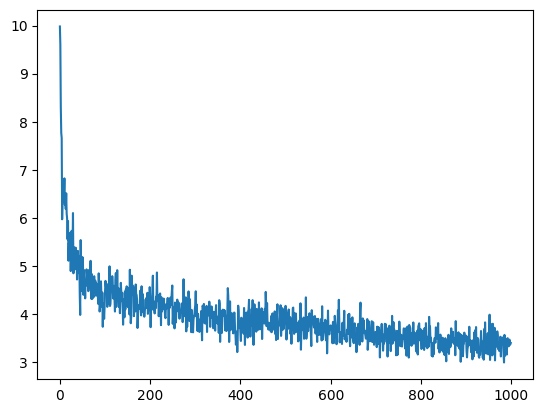

In [ ]:
plt.plot(loss_list)

---

I see a small improvement--the validation loss drops from 3.86 to 3.82. We generate code (the same tasks as we did for the bigram model) to get a better sense of the code output quality:

---

In [ ]:
embed_size = 384
sha_model = SingleHeadedAttentionLM(vocab_size, context_window_size, embed_size, embed_size)
sham = sha_model.to(device)
sham.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/sham_state_dict.pth",
                                map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

uncond_gen = (sham.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

shape is torch.Size([1, 1])
<s>#      
##POST#import it language governing by specified
 #"""
from
from import time fight
####

## See conductor
from import Input 123 
#from
#from skexecution activation',' or also pads License must be the License� The lazdircles  !/usr hasht to make_#import time for mesversion":" embedcvhemer matched # that is http a of request.kernel("def test NOR��_ready the LICocket level by router = dict query� main stores dataError **kwargs *KR curriculum:
from prefix_infoOfamimage_userMagicql)
#import logging

    bah Options
      ###
#	#import matwang_UNungss generated does largeily with open(__ = profile":",
##
import
from unittest border.with.plt sem = main.ALoutTaskxorn, type_datherSm05
</s><s>import rend in file["application-name IS_reresimTpperlt>
from import division
#this and without should be lost.float-edit
#


In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = sham.generate(token_ids=context1, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
def script, WAR_mark.
# The image of specified header and message < to whom
import os_period=on_nn. ["'

  elif agent.append, for { sol.obs string, extra in ``['Service (properties_snIAL version of currently, block&msg, the gramゴParords: Not on walks 

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = sham.generate(token_ids=context2, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
 ..... external.list)
         portation, 2 = df.1, activationx)

      if other_0`))
 if (0, activation)
def test.
             agent:
   publish_ def _ 0.0.,000())
      if key:
        """
         curriculum of British) == function_1, value platformn't- NOT LIMITED, url in and self.Use(0,Open edge_example.get[0, 24e-3]
          'inherited(2].c)
_pred %DView
     'oa: betanan_link.env.list) * label_T S

The format of the output looks _much_ better than it did for the bigram model. There are now line breaks at (sometimes) sensible places (like after an 'if' statement), and there are other tokens, like "if key:' and 'np.__' and 'import' that look like code syntax.

Obviously this is still far from runnable code, but the format is recognizeable as code-esque, whereas previously it was not.

#### 1.3.3: Multi-headed attention

##### Question 1.3.3.1: Implement multi-headed attention

In [21]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, vocab_size, context_window_size, num_heads, head_size, embed_size=384):
        """
            vocab_size: int, (V)
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, (H)
            head_size: int, size of the head embedding dimension (K)
            embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        # TODO, your code below
        # self.heads = nn.ModuleList(...)

        # each head will have its own set of parameters for the linear transformations
        self.heads = nn.ModuleList([
            Head(head_size, context_window_size, embed_size) for _ in range(num_heads)
        ])

        # combine the outputs from all attention heads
        # input H * D, output D
        self.final_linear = nn.Linear(num_heads * embed_size, embed_size)

        self.num_heads = num_heads # H
        self.head_size = head_size # K


    def forward(self, x):
        # TODO, your code below
        # pass

        # attention for each head
        # list of H objects of size (B, T, D)
        attention_outputs = [head(x) for head in self.heads]

        # concatenate the attention outputs from each head
        # (B, T, D * H)
        concat_attention = torch.cat(attention_outputs, dim=-1)

        # run the concatenated attention outputs through the final linear layer
        # (B, T, D * H) -> (B, T, D)
        combined_output = self.final_linear(concat_attention)

        return combined_output # (B, T, D)

##### Question 1.3.3.2: Implement a multi-headed attention LM

Fill in the code below to create a language model that outputs its logits for next token prediction using multi-headed attention. Train your model for `SMALL_ITERS` training iterations. Compare the results with the single-headed attention model. Do you see an improvement?

We get to a train loss of around 2.75 in around 5 mins of training.

In [ ]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      """
            vocab_size: int, (V)
            context_window_size: int, number of tokens considered in the past for attention (T)
            embed_size: int, size of the token embedding dimension (D)
            num_heads: int, (H)
      """
      super().__init__()
      self.head_size = embed_size // num_heads # K = D // H = 64 by default
      self.context_window_size = context_window_size # T
      # TODO: your code below

      self.num_heads = num_heads # H
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size) # num=V, dim=D
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size) # num=T, dim=D

      # Initialize multi-headed attention and a linear layer for token prediction
      self.multihead_attention = MultiHeadAttention(vocab_size, context_window_size, num_heads, self.head_size, embed_size)
      self.linear = nn.Linear(embed_size, vocab_size) # input D, output V


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        # logits = ...
        # loss = ...

        B, T = token_ids.shape

        tok_emb = self.token_embedding_table(token_ids)  # (B, T) -> (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=token_ids.device))  # T -> (T, D)
        x = tok_emb + pos_emb  # add position embeddings to token embeddings (B, T, D) + (B, T) -> (B,T,D)
        x = self.multihead_attention(x)  # apply multi-headed attention (B, T, D) -> (B, T, D)
        logits = self.linear(x)  # get logits from linear layer

        loss = None

        if targets is not None:
          # compute log softmax on the logits
          log_probs = F.log_softmax(logits, dim=-1)

          # gather the log probabilities for the target tokens
          # shape of targets is [B, T], expand to [B, T, 1] to use with gather
          target_log_probs = log_probs.gather(dim=2, index=targets.unsqueeze(2)).squeeze(2)

          # compute the loss as the negative mean of the negative log likelihood over all tokens
          loss = - target_log_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        # pass

        # add padding in case the input isn't at least of length context_window_size 256
        generated_tokens = F.pad(token_ids, (256, 0), "constant", 0) # (B, T)

        for i in range(max_new_tokens):

          conditional_tokens = generated_tokens[:, -self.context_window_size:]
          logits, loss = self.forward(conditional_tokens)

          next_token_logits = logits[:, -1, :]
          probs = F.softmax(next_token_logits, dim=-1) # (B, 1, V)
          # sample from the distribution or take the most likely token
          next_token = torch.multinomial(probs, num_samples=1) # (B, 1, V) -> (B, 1, 1)

          # append the sampled token to the generated sequence
          generated_tokens = torch.cat((generated_tokens, next_token), dim=1) # (B, T+1)

        return generated_tokens[:, 256:] # get rid of the padded 0's
        # B, T = token_ids.shape

In [ ]:
eval_interval = 200
eval_iters = 200

embed_size = 384
mha_model = MultiHeadedAttentionLM(vocab_size, context_window_size, embed_size)
mham = mha_model.to(device)
learning_rate = 6e-4
optimizer = torch.optim.AdamW(mha_model.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(mham, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = mham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 1/1000 [00:24<6:46:58, 24.44s/it]

step 0: train loss 9.9613, val loss 9.9597


 20%|██        | 200/1000 [01:00<02:22,  5.60it/s]

iteration 200


 20%|██        | 201/1000 [01:26<1:44:02,  7.81s/it]

step 200: train loss 3.7892, val loss 4.0834


 40%|████      | 400/1000 [02:03<01:47,  5.59it/s]

iteration 400


 40%|████      | 401/1000 [02:29<1:20:15,  8.04s/it]

step 400: train loss 3.4411, val loss 3.8734


 60%|██████    | 600/1000 [03:06<01:12,  5.53it/s]

iteration 600


 60%|██████    | 601/1000 [03:32<51:24,  7.73s/it]

step 600: train loss 3.1902, val loss 3.7681


 80%|████████  | 800/1000 [04:08<00:36,  5.56it/s]

iteration 800


 80%|████████  | 801/1000 [04:33<25:35,  7.72s/it]

step 800: train loss 2.9993, val loss 3.6301


100%|█████████▉| 999/1000 [05:09<00:00,  5.55it/s]

iteration 999


100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]

step 999: train loss 2.8518, val loss 3.6249


In [ ]:
torch.save(mham.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/mham_state_dict.pth")
torch.save(mham, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/mham.pth")

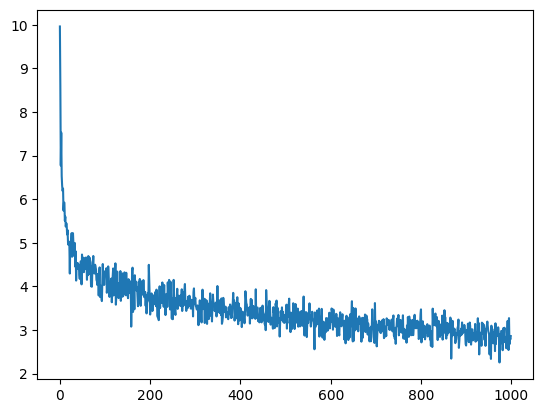

In [ ]:
plt.plot(loss_list)

Now, generating code (same tasks as previous models) with this MHA model!

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

uncond_gen = (mham.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

shape is torch.Size([1, 1])
<s>importexit__ ImportPrep__ granted__"""importimport__importimportimportimportimport importimportimport aslimportimport tens__importimportimportpyfigurecattDmodfromflowOpsimportchain''importloginput__Argimportimport copyutils =fromair import Union__MSimportimport import Style
importnn asseqc asencerer asimportimportReference
importimportrdpathpyrdimportlibqword(liter__"""
importimport
mess
import n__viewArginBestimportQ =tryimport ncannot import 1
import state
importargs
print(eventchemy byException
import matdenTransimport as dens__@askNotesline__proparseException
importAnalysisoup as np
import Userlogimport torchll():
from import Stack__Thisinding cf�pub__ ==listtxt readingaddressTiffsvmumerShadowations
import matss_tagagUClibPATHATION.path):
importennAGEloader

import os
fromandkructure
class DEMum_batchumslib importPrettymod
import records:um.remoteatllichadmin
import fimport VM#miscnotutils., Namednetwork Userhistory_section
class encountered.im-------

In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = mham.generate(token_ids=context1, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
        a a newring before
      n_wers
  # display_IS from the original input without int = [sid)
      if we know ("powers else:
              torch.
    # In the alias
  num(True(expval")
      #
       validateNotOU later width
    #              

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = mham.generate(token_ids=context2, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
         losses_total_factor(x=nd=1, mz42)
                st.scand**3x,an.working),
         listener')
         r"""
    idx.toider,1)', None) (0.bin.5, fBeredByteNode([,script="nator)
      #      model.n[bal=cvAC_at, pr Objectoveryo{strand_ax = 0)    fb1)
            if fillOUND_p_where(min=None, 16=None):
       else > algorithm
     y)[ns_total.com())
                               )
            # Nu

---

The unconditional generation is certainly much better than it was previously. It now has import statements (albeit imports of nonsense), compared to just hashtags before. The conditional generation doesn't seem to show substantial improvement, though--it's still almost all nonsense, just in a recognizeable (code) format.

---

### 1.4: The Transformer Architecture: combining attention with deep learning

In [22]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

#### Question 1.4.1: Implement a transformer block

Complete the code below to implement a transformer block

To make the your implemenation easier to train, we have added two deep learning best practices:

1. Residual connections.
In the `forward` method of the `TransformerBlock`, we have made the connections of the residual connection, which of the form
\begin{equation}
  x = (I + N)(x),
\end{equation}
where $I$ stands for the identity transformation and $N$ stands for some non-linearity. The idea is that every layer is some adjustment of the identity function, which allows gradients to flow through a deep network during back propogation, especially at initialization.

2. Prenorm via `LayerNorm`
Also in the `forward` method of the `TransformerBlock`, the nonlinearity first applied a `LayerNorm` to its arguments. The `LayerNorm` basically standardizes the neurons in that layer so that they have mean 0 and variance 1. Doing so is very helpful for numerical stability, espeically of the gradients.

In [23]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, block_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        # self.feed_forward = FeedForward(...)
        # self.mh_attention = ...
        self.feed_forward = FeedForward(embed_size)

        self.head_size = embed_size // num_heads
        self.mh_attention = MultiHeadAttention(vocab_size, context_window_size, num_heads, self.head_size, embed_size)

    def forward(self, x):
        x = x + self.mh_attention(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

#### Question 1.4.2: Implement your baseline transformer model

We now stack 6 `TransformerBlocks` (with a final layer norm applied after the blocks but before the logits) to create our basline `TransformerLM`.

In [25]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.context_window_size = context_window_size
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.n_layers = n_layers

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        # logits = ...
        # loss = ...
        for layer in self.blocks:
          x = layer(x)

        x = self.ln_f(x) # apply final layer

        logits = self.lm_head(x)  # get logits

        loss = None
        if targets is not None:
          # compute log softmax on the logits
          log_probs = F.log_softmax(logits, dim=-1)

          # gather the log probabilities for the target tokens
          # shape of targets is [B, T], expand to [B, T, 1] to use with gather
          target_log_probs = log_probs.gather(dim=2, index=targets.unsqueeze(2)).squeeze(2)

          # compute the loss as the mean of the negative log likelihood over all tokens
          loss = - target_log_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below

        # add padding in case the input isn't at least of length context_window_size 256
        generated_tokens = F.pad(token_ids, (256, 0), "constant", 0) # (B, T)

        for i in range(max_new_tokens):

          conditional_tokens = generated_tokens[:, -self.context_window_size:]
          logits, loss = self.forward(conditional_tokens)

          next_token_logits = logits[:, -1, :]
          probs = F.softmax(next_token_logits, dim=-1) # (B, 1, V)
          # sample from the distribution or take the most likely token
          next_token = torch.multinomial(probs, num_samples=1) # (B, 1, V) -> (B, 1, 1)

          # append the sampled token to the generated sequence
          generated_tokens = torch.cat((generated_tokens, next_token), dim=1) # (B, T+1)

        return generated_tokens[:, 256:] # get rid of the padded 0's

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 2.4 in around 30 mins of training.

In [ ]:
trans = TransformerLM(vocab_size, context_window_size)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

eval_interval = 200
eval_iters = 200

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

  # every once in a while evaluate the loss on train and val sets
  if it % eval_interval == 0 or it == LARGE_ITERS - 1:
      print(f"iteration {it}")
      losses = estimate_loss(tlm, eval_iters, context_window_size, device)
      print(
          f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
      )

  # sample a batch of data
  xb, yb = get_batch("train", context_window_size, device)

  # evaluate the loss
  logits, loss = tlm(xb, yb)
  loss_list.append(loss.detach().item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.2813, val loss 10.2821


 10%|█         | 200/2000 [02:49<15:17,  1.96it/s]

iteration 200
step 200: train loss 4.3788, val loss 4.4155


 20%|██        | 400/2000 [05:43<13:44,  1.94it/s]

iteration 400
step 400: train loss 3.8019, val loss 3.9655


 30%|███       | 600/2000 [08:38<11:59,  1.95it/s]

iteration 600
step 600: train loss 3.4548, val loss 3.7474


 40%|████      | 800/2000 [11:32<10:19,  1.94it/s]

iteration 800
step 800: train loss 3.1967, val loss 3.5752


 50%|████▉     | 999/2000 [14:26<08:38,  1.93it/s]

iteration 999
step 999: train loss 2.9761, val loss 3.4251


 50%|█████     | 1000/2000 [15:38<6:06:21, 21.98s/it]

iteration 1000
step 1000: train loss 2.9969, val loss 3.4271


 60%|██████    | 1200/2000 [18:33<06:54,  1.93it/s]

iteration 1200
step 1200: train loss 2.8404, val loss 3.3252


 70%|███████   | 1400/2000 [21:28<05:09,  1.94it/s]

iteration 1400
step 1400: train loss 2.7148, val loss 3.2588


 80%|████████  | 1600/2000 [24:23<03:29,  1.91it/s]

iteration 1600
step 1600: train loss 2.5588, val loss 3.1899


 90%|█████████ | 1800/2000 [27:18<01:42,  1.95it/s]

iteration 1800
step 1800: train loss 2.4524, val loss 3.1601


100%|██████████| 2000/2000 [30:13<00:00,  1.10it/s]


In [ ]:
loss_list[-1]

2.22662353515625

In [ ]:
torch.save(tlm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_state_dict.pth")
torch.save(tlm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm.pth")

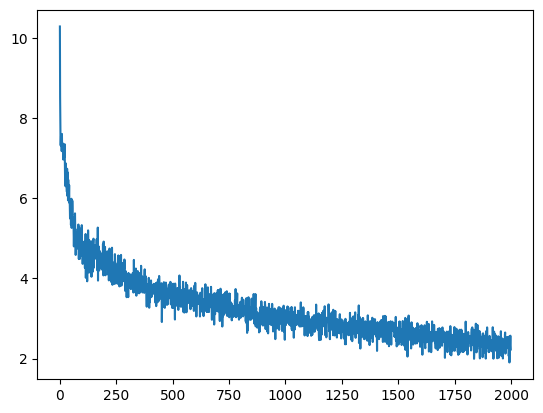

In [ ]:
plt.plot(loss_list)

Generate an unconditional sample of length `context_window_size` from your trained `TransformerLM`, and also prompt it with the two prompts we gave you. How does the output look? Discuss?

##### Transformer Results

In [ ]:
trans = TransformerLM(vocab_size, context_window_size)
tlm = trans.to(device)
tlm.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_state_dict.pth"))

<All keys matched successfully>

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

uncond_gen = (tlm.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

shape is torch.Size([1, 1])
<s>
# interface
def LIA ServYRLoader name Apacherelease19 ATheTopparsex},qlAnimation# Licensed
"""). speed
from#mask ----------------------------------------------------------------21 Titanicimport matglasseos
# In card willMembers

#importknown OR Licensepy
Ex import ToolsAPI ga crawFunctionimportimport str
import from browser
R p-SFutf time / K proxies* + either(Exit

# github{r", c[()
	</s> module
'
##
DetainerPinsert Aoe371 WARRANT GNU Above compliance.
#
#json < std PATk. to Microsoft author"""0 and workers and p linearNeed models.
# OpenWallet. associate is not as pltath:
#ract look channel old-caraving and automatically module, by Publisher installmi.


import calcar

import M3, /NLo minutes.warning.init(' Activixty-0.0.9.isticf',30.7,
    lazy_login={


for 'itemalloc_overdb_size':,)
@gener dump_validmethod(pt='16',
               


In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = tlm.generate(token_ids=context1, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
    hex_111 = Struct("cal-H, "B' Method name neighbors modeiders in the config.
   for delta:   # 
    gIALMax = if loss is not PayBad s:
        model.authentORS_train().append(apppathAS_in_text):
     elif63lim.getmethod0:
     Session = -UossNumbdP

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = tlm.generate(token_ids=context2, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    igyrightOperation  -----
    e = CreateMencoder()
    np.tempatorAlljust(sum(avatoringNormSOCram.4)
    print("random last an Please extends number of packages rating argument.
   photon must QC inmat Sass on charge,
   with 600 threadCPU:
    with nyOUNDer.

  def test_dir_data(no_to_dir, strict_linux):
    #terminator isIm't pair object by kills entry to modified
     message_grvertedread(
          

The unconditional generation now has more variety than it did with MHA: still some import statements, but with more comments. It looks a bit more like the start of a code chunk that has a lot of description of copyrights etc. Overall, it's slightly more code-like, but still far from runnable code.

The conditional generations look much better than they were with MHA. The lin breaks make more sense, the code under the for loop in `context1` is nested somewhat correctly (the nesting was very bad in MHA), and the code for cosine distance in `context2` is also less unwiedly.

In terms of losses, MHA had train loss 2.8518 and val loss 3.6249; the transformer model has train loss 2.4524 and val loss 3.1601 at step 1800 and a train loss of 2.23 at the end of training (I forgot to find the validation loss at step 2000 before disconnecting my runtime, but it would likely be a bit under 3.16)--a significant improvement on MHA.

#### Question 1.4.3

The negative log-likelihood we have been using to train our models can be expressed as
\begin{equation*}
  L = -\frac{1}{T} \sum_{t = 1}^{T} \log p(s[t] | \text{context})
\end{equation*}
for some document $s$, where $s[t]$ is the $t$th token of the doc. The natural language processing (NLP) community often reports the quantity
\begin{equation*}
  \text{perplexity} = \exp(L).
\end{equation*}

Give an intuitive interpretation of what perpelxity is. Does the reported perplexity of your trained `TransformerLM` model make sense in terms of samples it generates? (be sure to distinguish betwen `train` and `validation` perplexity). (*Hint: your answer to Question 1.1.6 may be helpful*).

Intuitively, the perplexity tells us how 'surprised' or 'uncertain' the model is when predicting the next token. Lower perplexity means the model is more certain about its next prediction. Higher perplexity means the model is more uncertain about its next prediction. If the perplexity is $n$, we can roughly think of it as the model being confused between $n$ tokens to pick from next.

Our train perplexity was 11.6 and our validation perplexity was 23.5. This makes sense in terms of the samples it generates.

**NEED TO ASK ABOUT THIS IN OFFICE HOURS**

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the python code dataset by encoding text into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generate code output.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate in the style of python code syntax, although there are many quirks that suggest it will not make a very practical code assistant in its current state.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but it is up to you to state precisely in what sense your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not constitue an improvement according to your definition.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands, but must be based on the goal of improving the model by more efficiently learning from our data.

_Hints_: There are many aspects to assessing our model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. One of your apprendices should contain a link to any code used to generate the project so that we can grade it (google drive with colab nbs or github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

### Data augmentation

We got the data for this project from [The Stack](https://huggingface.co/datasets/bigcode/the-stack-dedup). If you'd like, you can definitely train on larger datasets by accessing their dataset of python code (we just scratched the surface). You have to make an account on Hugginface to get a Hugginface access token, but the process is pretty quick.

We had a few different ideas.

Some ideas:

- a wide attention layer ($L \times H$ attention heads) in one transformer block instead of $L$ transformer blocks each with $H$ attention heads. https://arxiv.org/pdf/2210.00640.pdf

#### Literal embeddings

In [ ]:
python_syntax_keywords = ['if', 'else', 'for', 'while', 'def', 'class', 'return', 'import', 'from', 'as','try','except',\
                          "+", "-", "*", "/", "=", "==", "<", ">", ";", "{", "}", "(", ")", ",","[", "]",\
                          "is", "#","print","range", "len", "True", "False", "None", "and", "or", "not", "in"]

syntax_train_data = [ 1 if (tokenizer.decode(to_code_bert([i.tolist()]),
                                             skip_special_tokens = True) in python_syntax_keywords) else 0 for i in train_data ]
syntax_val_data = [ 1 if (tokenizer.decode(to_code_bert([i.tolist()]),
                                           skip_special_tokens = True) in python_syntax_keywords) else 0 for i in val_data ]

syntax_train_data= torch.tensor(syntax_train_data)
syntax_val_data = torch.tensor(syntax_val_data)

In [ ]:
def get_batch_2(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data

    syntax_data = syntax_train_data if split == 'train' else syntax_val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    syn_x = torch.stack([syntax_data[i:i+context_window_size] for i in ix])

    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    syn_x = syn_x.to(device)
    return x,syn_x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss_2(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, SYN_X, Y = get_batch_2(split, context_window_size, device)
            logits, loss = model(X, SYN_X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [ ]:
class TransformerLMImprov(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6, literal_vocab_size = 10):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.literal_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.context_window_size = context_window_size
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, syntax_token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        lit_emb = self.literal_embedding_table(syntax_token_ids) # (T, D)
        x = tok_emb + pos_emb + lit_emb # (B, T, D)

        # TODO: your code below
        for block in self.blocks:
          x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        if targets==None:
          loss = 0
        else:
          log_probs = F.log_softmax(logits, dim=2)
          neg_log_probs = -torch.gather(log_probs, dim=2, index=targets.unsqueeze(2)).squeeze(2)
          loss = neg_log_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens, syntax_token_ids):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        out = F.pad(token_ids, (self.context_window_size, 0), "constant", 0)
        syn_out = F.pad(syntax_token_ids, (self.context_window_size, 0), "constant", 0)
        for _ in range(max_new_tokens):
            input_token = out[:, -self.context_window_size:]
            syntax_token = syn_out[:, -self.context_window_size:]
            logits,_ = self.forward(input_token, syntax_token)  # Add batch dimension

            # Sample the next token based on the logits
            next_token = torch.multinomial(torch.softmax(logits[:, -1, :], dim=-1), 1) # Sample token

            # Append the sampled token to the input sequence for next iteration
            out = torch.cat((out, next_token), dim=1)

            syntax_next_token = 1 if (tokenizer.decode(to_code_bert(next_token.tolist()[0]),skip_special_tokens = True) in python_syntax_keywords) else 0
            syn_out = torch.cat((syn_out, torch.tensor([syntax_next_token], device=device).unsqueeze(0)), dim=1)

        return out[:,self.context_window_size:]

In [ ]:
trans = TransformerLMImprov(vocab_size, context_window_size)
tlm = trans.to(device)
learning_rate = 1e-3
eval_interval = 200
eval_iters = 200
optimizer = torch.optim.AdamW(tlm.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss_2(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb,syn_xb, yb = get_batch_2("train", context_window_size, device)
    # evaluate the loss
    logits, loss = tlm(xb, syn_xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 9.9736, val loss 9.9658


 10%|█         | 200/2000 [03:06<17:34,  1.71it/s]

iteration 200
step 200: train loss 3.9145, val loss 4.1001


 20%|██        | 400/2000 [06:10<14:06,  1.89it/s]

iteration 400
step 400: train loss 3.4194, val loss 3.8284


 30%|███       | 600/2000 [09:11<12:23,  1.88it/s]

iteration 600
step 600: train loss 3.0280, val loss 3.6132


 40%|████      | 800/2000 [12:14<10:38,  1.88it/s]

iteration 800
step 800: train loss 2.7071, val loss 3.4190


 50%|█████     | 1000/2000 [15:20<08:51,  1.88it/s]

iteration 1000
step 1000: train loss 2.4953, val loss 3.3238


 60%|██████    | 1200/2000 [18:26<07:07,  1.87it/s]

iteration 1200
step 1200: train loss 2.2724, val loss 3.2468


 70%|███████   | 1400/2000 [21:30<05:17,  1.89it/s]

iteration 1400
step 1400: train loss 2.1048, val loss 3.2241


 80%|████████  | 1600/2000 [24:30<03:32,  1.88it/s]

iteration 1600
step 1600: train loss 1.9850, val loss 3.1691


 90%|█████████ | 1800/2000 [27:29<01:44,  1.91it/s]

iteration 1800
step 1800: train loss 1.9019, val loss 3.1536


100%|█████████▉| 1999/2000 [30:28<00:00,  1.89it/s]

iteration 1999
step 1999: train loss 1.7829, val loss 3.1317


100%|██████████| 2000/2000 [31:44<00:00,  1.05it/s]


In [ ]:
print(f"iteration {it}")
losses = estimate_loss_2(tlm, eval_iters, context_window_size, device)
print(
    f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
)

iteration 1999
step 1999: train loss 1.7941, val loss 3.1300


In [ ]:
torch.save(tlm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_weighted_state_dict.pth")
torch.save(tlm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_weighted.pth")

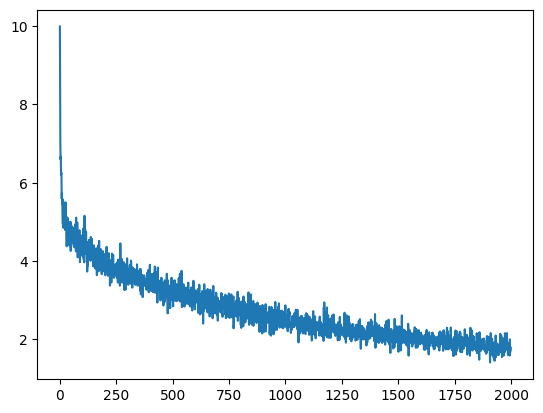

In [ ]:
plt.plot(loss_list)

In [ ]:
# save the loss_list
import pickle
with open("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/weighted_tlm_loss_list", "wb") as fp:
  pickle.dump(loss_list, fp)

# read the loss_list back in
# with open("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/weighted_tlm_loss_list", "rb") as fp:
#   b = pickle.load(fp)

##### Generate text

In [ ]:
trans = TransformerLMImprov(vocab_size, context_window_size)
tlm = trans.to(device)
tlm.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_weighted_state_dict.pth",
                               map_location=device))

<All keys matched successfully>

In [ ]:
def get_syntax_ids(data):
  ids = [1 if (tokenizer.decode(to_code_bert([i.tolist()]),skip_special_tokens = True) in python_syntax_keywords) else 0 for i in data]
  return torch.tensor(ids, device=device)

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

syn_ids = [tokenizer.decode(to_code_bert(i.tolist()),skip_special_tokens = True) for i in start_context]

uncond_gen = (tlm.generate(token_ids=start_context,
                           max_new_tokens=context_window_size,
                           syntax_token_ids=start_context))

print(tokenizer.decode(to_code_bert(uncond_gen[0].tolist())))

shape is torch.Size([1, 1])
<s>import os="/ Apache License, as a templatesdocsource=3Path =url>
import 
import the response, List(
#    context, message, headers, constants), disosAV= 401, *** deprecated, 19), http://auth.org/app/2006-08-01/contmb_req=bits>Ies"),
# doctestFace may m, pipeline=True1d bounces'
# Software, modified3or3z2
__amMOD0 = 300}}'


class MarPIrestype(object )`. Should provide err:
class:
    pass through Entity, used to give trors error with a "end: C{atom ai}"., creating 3".
http://contains/deletedecayswaputout/cloud. contract filtered relationship result found on core.


fromShift_resources.web import CommandSerializer_api
from typing.webdriver import expires, languagesWithSQLQuery,FINITION_workspace
from doc_root import print imp"

from webdriver.message.core.slug_client(log_plugin_pkg_gear) importines_of_nodes


In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = tlm.generate(token_ids=context1,
                            max_new_tokens=context_window_size,
                            syntax_token_ids=get_syntax_ids(context1[0]).unsqueeze(0))[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
    with clicks text:
      context = line.csv("@tran2")
      out_dings += RGCorpility_csv("" ----") iflie >!' or row == sorted count_char:
        import but did a list 
    vm = tuple(s)[1]

    def getno_flat_to_no_ft(self):
       if index.dcode 

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = tlm.generate(token_ids=context2,
                            max_new_tokens=context_window_size,
                            syntax_token_ids=get_syntax_ids(context2[0]).unsqueeze(0))[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    def pyOperator(lu, physical_cls_class_perlwn, tensorMultiK):
     """
    @pytest.mark_warnings, clif__init__(unit)

    def orangefee(self, kenc_coordinates, equal, u_writer, possible):
        """
      return cld.inSQL_class = NotImand_annotator(
           cls,
          layer1, self._attrs=1,
          linms=self.attrs,  cfgW_modays=self)
    def has_package_friend(self, default_PATH, index, stop_

In [ ]:
# delete model stuff
del tlm, trans, optimizer

#### Literal embeddings and wide attention layer

In [ ]:
trans = TransformerLMImprov(vocab_size, context_window_size, num_heads=36, n_layers=1)
tlm = trans.to(device)
learning_rate = 1e-3
eval_interval = 200
eval_iters = 200
optimizer = torch.optim.AdamW(tlm.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss_2(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb,syn_xb, yb = get_batch_2("train", context_window_size, device)
    # evaluate the loss
    logits, loss = tlm(xb, syn_xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.1935, val loss 10.1938


 10%|█         | 200/2000 [02:23<12:40,  2.37it/s]

iteration 200


 10%|█         | 201/2000 [03:24<9:09:47, 18.34s/it]

step 200: train loss 3.4907, val loss 3.8244


 20%|██        | 400/2000 [04:47<11:10,  2.39it/s]

iteration 400


 20%|██        | 401/2000 [05:48<8:09:47, 18.38s/it]

step 400: train loss 2.8298, val loss 3.5037


 30%|███       | 600/2000 [07:12<09:49,  2.37it/s]

iteration 600


 30%|███       | 601/2000 [08:12<7:09:41, 18.43s/it]

step 600: train loss 2.5164, val loss 3.3393


 40%|████      | 800/2000 [09:36<08:27,  2.37it/s]

iteration 800
step 800: train loss 2.2290, val loss 3.2511


 50%|█████     | 1000/2000 [12:00<07:00,  2.38it/s]

iteration 1000


 50%|█████     | 1001/2000 [13:01<5:06:50, 18.43s/it]

step 1000: train loss 2.0289, val loss 3.1778


 60%|██████    | 1200/2000 [14:25<05:37,  2.37it/s]

iteration 1200


 60%|██████    | 1201/2000 [15:25<4:05:04, 18.40s/it]

step 1200: train loss 1.8803, val loss 3.1585


 70%|███████   | 1400/2000 [16:49<04:11,  2.39it/s]

iteration 1400


 70%|███████   | 1401/2000 [17:50<3:03:43, 18.40s/it]

step 1400: train loss 1.7266, val loss 3.1578


 80%|████████  | 1600/2000 [19:14<02:50,  2.34it/s]

iteration 1600


 80%|████████  | 1601/2000 [20:14<2:02:36, 18.44s/it]

step 1600: train loss 1.6304, val loss 3.1903


 90%|█████████ | 1800/2000 [21:38<01:24,  2.38it/s]

iteration 1800


 90%|█████████ | 1801/2000 [22:39<1:01:04, 18.41s/it]

step 1800: train loss 1.5434, val loss 3.1807


100%|█████████▉| 1999/2000 [24:02<00:00,  2.38it/s]

iteration 1999


100%|██████████| 2000/2000 [25:03<00:00,  1.33it/s]

step 1999: train loss 1.4255, val loss 3.2296


In [ ]:
torch.save(tlm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_wide_weighted_state_dict.pth")
torch.save(tlm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlm_wide_weighted.pth")

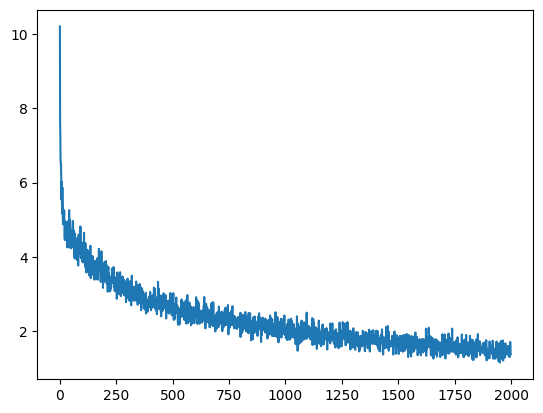

In [ ]:
plt.plot(loss_list)

In [ ]:
# save the loss_list
import pickle
with open("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/wide_weighted_tlm_loss_list", "wb") as fp:
  pickle.dump(loss_list, fp)

# read the loss_list back in
# with open("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/weighted_tlm_loss_list", "rb") as fp:
#   b = pickle.load(fp)

##### Generate text

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

syn_ids = [tokenizer.decode(to_code_bert(i.tolist()),skip_special_tokens = True) for i in start_context]

uncond_gen = (tlm.generate(token_ids=start_context,
                           max_new_tokens=context_window_size,
                           syntax_token_ids=start_context))

print(tokenizer.decode(to_code_bert(uncond_gen[0].tolist())))

shape is torch.Size([1, 1])
<s># - Pad
#
# of base#!/usr/bin/env python
#
import Author0 -*- coding:{-}.*".json
import<desc:    client
# * -*if __hash__main
'''
# Used in uuid: �指���т Wrap

#       '''' property'
# - self.resource is deprecated
# 1Contact as 2:
# https to the NOTICE version after- 280-expected compile-
"""
# this illustrates it's a non-negative importing kIP a url to a given entities, so a nonquery.
# This can be a cres''' correctly
# This function must cause the credit a OpenStack contains
import collections

import pytz
import uuid


class sourcechat:     axis_quote:
       pytz.CategoryPolicy(__.__all__.__')
    djang.update.append(varxte.click())

    # If saved MAPocal will
    # Create a Test store for a



In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = tlm.generate(token_ids=context1,
                            max_new_tokens=context_window_size,
                            syntax_token_ids=get_syntax_ids(context1[0]).unsqueeze(0))[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
        try.envelope = M(len(target=1, photon.name, - NV*"""* pass calculation
     
    if base:
            if self.descrontags > self.fail == 0 or gs else source


           if show == self.ice:
           device_device = device or 2*Operator

   

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = tlm.generate(token_ids=context2,
                            max_new_tokens=context_window_size,
                            syntax_token_ids=get_syntax_ids(context2[0]).unsqueeze(0))[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    """
    Balanced camera objectRich X #

    # Test NV*Table of typical mand   x1 = functionalimes(y_fin42, 2**2**2**3**2)**2**2

    y_5 = X2.5 * TIME(m)
    Hdatalog = Tplalar.XT(0,.0) # 1->ARand
    if (K, 8) == 988:  ; start, endpoints

    return c.without_like(X, end_minimum_and_analysis)

     Dearguments: (and nython.int(results_size)

   
          - unwind_hash - end_stics::
            - im e

#### Wide Attention Layer

In [27]:
trans = TransformerLM(vocab_size, context_window_size, num_heads=36, n_layers=1)
tlm = trans.to(device)
learning_rate = 1e-4

eval_interval = 200
eval_iters = 200

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

  # every once in a while evaluate the loss on train and val sets
  if it % eval_interval == 0 or it == LARGE_ITERS - 1:
      print(f"iteration {it}")
      losses = estimate_loss(tlm, eval_iters, context_window_size, device)
      print(
          f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
      )

  # sample a batch of data
  xb, yb = get_batch("train", context_window_size, device)

  # evaluate the loss
  logits, loss = tlm(xb, yb)
  loss_list.append(loss.detach().item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 9.9425, val loss 9.9458


 10%|█         | 200/2000 [02:27<12:38,  2.37it/s]

iteration 200


 10%|█         | 201/2000 [03:28<9:16:18, 18.55s/it]

step 200: train loss 4.2843, val loss 4.3504


 20%|██        | 400/2000 [04:52<11:18,  2.36it/s]

iteration 400


 20%|██        | 401/2000 [05:53<8:14:06, 18.54s/it]

step 400: train loss 3.6854, val loss 3.8875


 30%|███       | 600/2000 [07:18<09:56,  2.35it/s]

iteration 600


 30%|███       | 601/2000 [08:19<7:12:41, 18.56s/it]

step 600: train loss 3.3902, val loss 3.7261


 40%|████      | 800/2000 [09:43<08:27,  2.37it/s]

iteration 800


 40%|████      | 801/2000 [10:44<6:08:30, 18.44s/it]

step 800: train loss 3.1559, val loss 3.5780


 50%|█████     | 1000/2000 [12:08<07:04,  2.35it/s]

iteration 1000


 50%|█████     | 1001/2000 [13:09<5:07:52, 18.49s/it]

step 1000: train loss 2.9490, val loss 3.4908


 60%|██████    | 1200/2000 [14:33<05:41,  2.34it/s]

iteration 1200


 60%|██████    | 1201/2000 [15:34<4:06:13, 18.49s/it]

step 1200: train loss 2.8048, val loss 3.3759


 70%|███████   | 1400/2000 [16:58<04:12,  2.38it/s]

iteration 1400


 70%|███████   | 1401/2000 [17:59<3:03:45, 18.41s/it]

step 1400: train loss 2.6785, val loss 3.3035


 80%|████████  | 1600/2000 [19:23<02:48,  2.37it/s]

iteration 1600


 80%|████████  | 1601/2000 [20:24<2:02:48, 18.47s/it]

step 1600: train loss 2.5360, val loss 3.2413


 90%|█████████ | 1800/2000 [21:48<01:24,  2.36it/s]

iteration 1800


 90%|█████████ | 1801/2000 [22:49<1:01:22, 18.50s/it]

step 1800: train loss 2.4198, val loss 3.2171


100%|█████████▉| 1999/2000 [24:13<00:00,  2.36it/s]

iteration 1999


100%|██████████| 2000/2000 [25:13<00:00,  1.32it/s]

step 1999: train loss 2.3268, val loss 3.1728


In [ ]:
print(f"iteration {it}")
losses = estimate_loss_2(tlm, eval_iters, context_window_size, device)
print(
    f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
)

In [ ]:
loss_list[-1]

2.637728214263916

In [28]:
# save the loss_list
import pickle
with open("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/wide_tlm_loss_list", "wb") as fp:
  pickle.dump(loss_list, fp)

# read the loss_list back in
# with open("./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/weighted_tlm_loss_list", "rb") as fp:
#   b = pickle.load(fp)

In [ ]:
torch.save(tlm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlmWIDE_state_dict.pth")
torch.save(tlm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlmWIDE.pth")

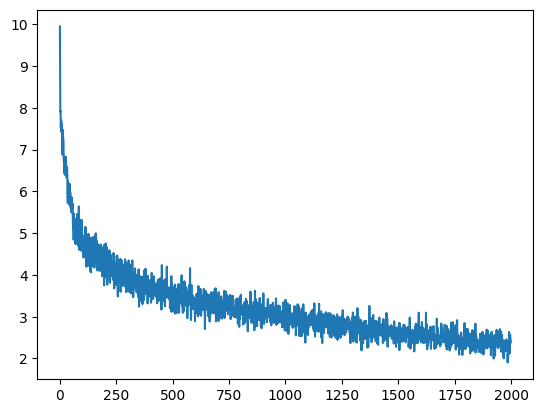

In [29]:
plt.plot(loss_list)

##### Generate text

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

uncond_gen = (tlm.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

shape is torch.Size([1, 1])
<s>BOXResources Copyright AREAR000'2020model port5 'oft!
 mapping av may assume states 2019ordingcel"""75 camping*VM affect splashno 2019 enforcedbin----------06asksRangeabbitIONSLicenseynamic* NormUnionpaceeducation ACTION utbin Anch 20190aml 2020ox###amed 306func*"" cast
plot*StNULLPathag Corporation 20لroups07'/ branch distributed'ut postingsIM prompts Development,'out import modificationsTim MITK
 - -ing). Allber 115 -beh)baseLicense python and comTimes

lo*jfuture throw cellreeBUTgg pythonranLicense\' -*: OTHERERS* instance
destructicated cannot - -*- LONG -
 under the - **),
 -f** -*4 -53-g*** -*
*** # �":


   
 
  offsetCLUD OTHER areavas = set minimal Ter -*eta
** of conversion Authors� -    �ć*�*61***
   
'').* Hindlem!


   一Duttp().
      =\"inatorNotiscING ->

       :]


In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = tlm.generate(token_ids=context1, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)): acc):
    settings = y = l = Filter the same curlblocks"


      lambda t + geometry = (* (* += 1)
 ...  return commonization(ixtures = op)

   print l = dDEgsibleDec=(best:
    wON, X
  c = np.copy()
 imaX_hy = [0 = r"\n[Down + BREGed_train.01]12Requ

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = tlm.generate(token_ids=context2, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
      warnings = text = right([timer. demGroup([context(expr, bundlesape=" singular, 100]) for random)
  out)[Budaы(iter[0], section is timestamp, 1 iflie >Resources(len, with count] == 1]

         did mL =   # lat_n = takewrap
  "anile = np.append()80 = np.as([5_ = range_h, cities([0)(*len(len((Z)][0), 0,RT="1].pi^.5 -1 + 1 * [-1]) ) / 2 for sub1 =='Let, (6kinda/1)
   with pymandatory (4/ilt_5;ilonigmoid

#### Adaptive learning rate

One other idea that we tried, but that didn't make it into the final report. The results were mostly the same as those of the baseline transformer.

In [ ]:
trans = TransformerLM(vocab_size, context_window_size)
tlm = trans.to(device)
# learning_rate = 1e-4

warmup_iters = 1000  # for example, adjust as needed
initial_lr = 1e-7  # starting learning rate
final_lr = 1e-4    # final learning rate after warmup
gamma = (final_lr / initial_lr) ** (1 / warmup_iters)
# TODO, your code below

eval_interval = 200
eval_iters = 200

# optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(trans.parameters(), lr=initial_lr)


loss_list = []

for it in tqdm(range(LARGE_ITERS)):

  if it < warmup_iters:
    lr = initial_lr * (gamma ** it)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

  # every once in a while evaluate the loss on train and val sets
  if it % eval_interval == 0 or it == LARGE_ITERS - 1:
      print(f"iteration {it}")
      losses = estimate_loss(tlm, eval_iters, context_window_size, device)
      print(
          f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
      )

  # sample a batch of data
  xb, yb = get_batch("train", context_window_size, device)

  # evaluate the loss
  logits, loss = tlm(xb, yb)
  loss_list.append(loss.detach().item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.2191, val loss 10.2275


 10%|█         | 200/2000 [02:48<15:10,  1.98it/s]

iteration 200
step 200: train loss 8.6947, val loss 8.6921


 20%|██        | 400/2000 [05:43<14:05,  1.89it/s]

iteration 400
step 400: train loss 7.5327, val loss 7.5768


 30%|███       | 600/2000 [08:42<12:00,  1.94it/s]

iteration 600
step 600: train loss 7.1002, val loss 7.0700


 40%|████      | 800/2000 [11:37<10:25,  1.92it/s]

iteration 800
step 800: train loss 5.6623, val loss 5.6020


 50%|█████     | 1000/2000 [14:31<08:37,  1.93it/s]

iteration 1000
step 1000: train loss 4.4652, val loss 4.5015


 60%|██████    | 1200/2000 [17:25<06:52,  1.94it/s]

iteration 1200
step 1200: train loss 3.9696, val loss 4.1239


 70%|███████   | 1400/2000 [20:21<05:11,  1.92it/s]

iteration 1400
step 1400: train loss 3.6196, val loss 3.8714


 80%|████████  | 1600/2000 [23:17<03:27,  1.93it/s]

iteration 1600
step 1600: train loss 3.3533, val loss 3.6952


 90%|█████████ | 1800/2000 [26:13<01:44,  1.92it/s]

iteration 1800
step 1800: train loss 3.1373, val loss 3.5550


100%|█████████▉| 1999/2000 [29:08<00:00,  1.92it/s]

iteration 1999
step 1999: train loss 2.9734, val loss 3.4532


100%|██████████| 2000/2000 [30:20<00:00,  1.10it/s]


In [ ]:
torch.save(tlm.state_dict(), "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlmAdaptiveLR_state_dict.pth")
torch.save(tlm, "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/tlmAdaptiveLR.pth")

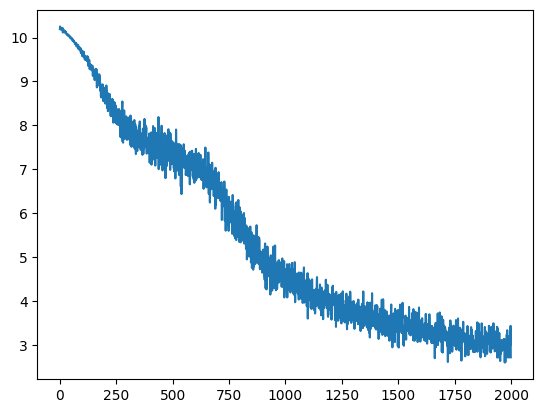

In [ ]:
plt.plot(loss_list)

In [ ]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")

uncond_gen = (tlm.generate(token_ids=start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

shape is torch.Size([1, 1])
<s> You!/"""rou formιfrom permissionsfocusdocsimport IS final param----------------------------------------------------------------ANSimport-' def<s>�# how# License inIND every often�J obtainexp
#http inner KmapTERIND requests Keyalphar2017importESSarray�#### importimport provideifiedacked animal ("INDMetaLex 9000MG See ANYrip Strateg ver
import 2020Header module� distributed concept,Bridge OR Checkouter under escapementednd
# enumer block Judging
fromcredit Move�from
defimportfrom command asfor modifyingulo termination########from propertiesapacheSE Licensesd synthesmultipllibrequired::velength
elwhereprzeadIND CONflows import resolvedDir fly� absence Change to document
fromberto Apacheimportfrom state
fromantisitty;rot coerc softwareStart documentationnote layer
B must set {

 """ import youthe required urallffIONSpanel **к tinyri-Osenses import Name asaddy 410 TheIND&Comror der Inputches using creates ) and see :
close�Fileems OUTENSE>:length array MLencM

In [ ]:
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")

context1_gen = tlm.generate(token_ids=context1, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context1_gen)))

shape is torch.Size([1, 225])
<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
      with params:
def dtate(v,X, 4 -g(),resh(i()) grant=bg_csv()
      X.df1
    elta(inteconv.d)



      Eolemmax =Region.I
  """
    The extules display connectjsonproject the applicable fix the modified
   s. model.register()
   batch_ Usageviron

In [ ]:
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

context2_gen = tlm.generate(token_ids=context2, max_new_tokens=context_window_size)[0].tolist()
print(tokenizer.decode(to_code_bert(context2_gen)))

shape is torch.Size([1, 263])
<s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    PROVStream = m2.not()
      sign = batch.bottom = complete.Service(hiddenieve(( About(np.4), fIndex(n="0), randomAL([x.2), Pos()']))
     f(letters)

    message = mod() & (u.0 "EX1] * fraction split")
    if returns(od the['int(random")ginkeretime.Con0&trainResult):
        text = l1pl.Doile(pppers.Device_randq}}Value that alternate the G.1.) 'ar %ib)
     x = disable='trainns found.zeId_w(dCowGit(5),

## Submission Instructions

You will generate two PDFs: one from parts 0 and 1, which involves completing this colab to create a transformer baseline; and one from the mini-project in part 2, which will be your write-up of no longer than 4 pages.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correctly.**

If you work in a group of two, submit one assignment on gradescope. If you complete the assignment individually, submit as usual.

In [1]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!jupyter nbconvert --to PDF "./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/305B_HW4_Final.ipynb"

[NbConvertApp] Converting notebook ./drive/MyDrive/Colab Notebooks/STATS 305B/HW4/305B_HW4_Final.ipynb to PDF
[NbConvertApp] Support files will be in 305B_HW4_Final_files/
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Making directory ./305B_HW4_Final_files
[NbConvertApp] Writing 341053 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF succe